In [ ]:
#!pip install yfinance

In [ ]:
import numpy as np
#import pyflux as pf
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


<h1>Data:</h1>

<ul>

<li>2020-09-01 - 2021-05-14	</li>

</ul>

<h1>Analysis</h1>

In [ ]:
df = pd.read_csv('final.csv')
df = df.reset_index()

In [ ]:
fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name="Price"),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.numb_pos, name = 'Number of positive posts'),
              row=1, col=2)
fig.add_trace(go.Scatter(x=df.Date, y=df.numb_neg, name='Number of negative posts'),
              row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Suma, name='Trends'),
              row=2, col=2)
fig.show()


In [ ]:
df['numb_pos_pct'] = df['numb_pos'].pct_change()*5
df['numb_neg_pct'] = df['numb_neg'].pct_change()*5 
df['trend_pct'] = df['Suma'].pct_change()*100

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,name='Close price'))
fig.add_trace(go.Bar(x=df.Date, y=df.numb_neg_pct,name='Negative pct change'))
fig.add_trace(go.Bar(x=df.Date, y=df.numb_pos_pct,name='Positive pct change'))
fig.show()


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,name='Close price'))
fig.add_trace(go.Bar(x=df.Date, y=df.trend_pct,name='Trend pct change'))
fig.show()


In [ ]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name="Price"),
              row=1, col=1)
fig.add_trace(go.Bar(x=df.Date, y=df.Suma, name = 'Trend'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Price'),
              row=1, col=2)
fig.add_trace(go.Bar(x=df.Date, y=df.trend_pct, name='Trend pct change'),
              row=1, col=2)
fig.show()


<h1>Model ARIMA</h1>

In [ ]:
!pip install pmdarima
!pip install git+https://github.com/RJT1990/pyflux


In [ ]:
import numpy as np
import pyflux as pf
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
%matplotlib inline


In [ ]:
data = df.filter(['Date', 'Close'])
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')

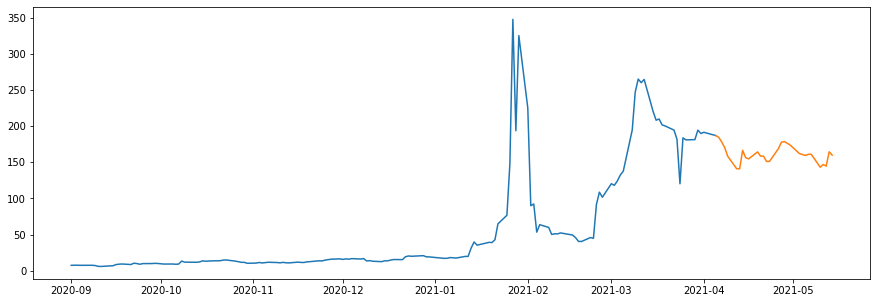

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
train = data[:148]
test = data[-30:]
plt.plot(train)
plt.plot(test)

In [ ]:
test

,Close
Date,
2021-04-05,186.949997
2021-04-06,184.500000
2021-04-07,177.970001
2021-04-08,170.259995
2021-04-09,158.360001
2021-04-12,141.089996
2021-04-13,140.990005
2021-04-14,166.529999
2021-04-15,156.440002


In [ ]:
arima_model = auto_arima(train, start_p=0, start_q=0, seasonal=False, start_P=0,start_Q=0,test='adf', stationary=True)

In [ ]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  148
Model:               SARIMAX(5, 0, 2)   Log Likelihood                -689.926
Date:                Thu, 27 May 2021   AIC                           1397.852
Time:                        22:17:57   BIC                           1424.827
Sample:                             0   HQIC                          1408.812
                                - 148                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.6245     10.222      0.452      0.651     -15.410      24.659
ar.L1          1.2042      0.087     13.851      0.000       1.034       1.375
ar.L2         -0.5744      0.196     -2.925      0.0

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods=30), index=test.index)
prediction.columns=['preds']

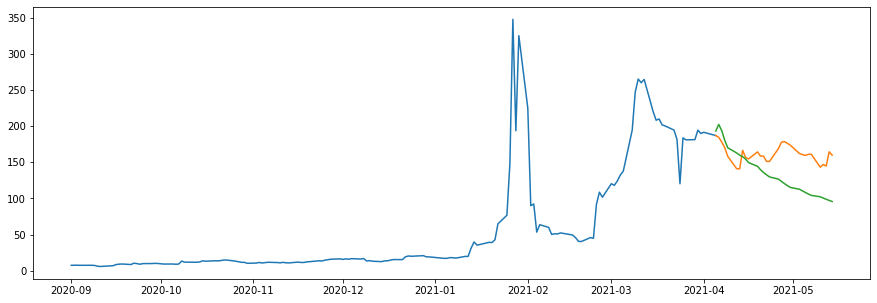

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(train)
plt.plot(test)
plt.plot(prediction)

<h1>ARIMAX</h1>

In [ ]:
df_arimax = df.filter(['Date', 'Close', 'Volume', 'numb_pos', 'Suma' ])
df_arimax['Date'] = pd.to_datetime(df_arimax['Date'], format='%Y-%m-%d')
df_arimax = df_arimax.set_index('Date')

In [ ]:
df_arimax_train = df_arimax[:147] #Split data into training and testing
df_arimax_test = df_arimax[-30:]

In [ ]:
def get_arimax(formula='Close~numb_pos', max_ar=5, max_ma=5, data=data): #function for selecting the best delays
  d=dict()
  for reg in ['MLE']:
    for ar in range(0,max_ar):
      for ma in range(0,max_ma):
        model = pf.ARIMAX(data=data, formula=formula,
                    ar=ar, ma=ma, family=pf.Normal())
        aic1 = model.fit(reg)
        d[aic1.aic] = ar,ma
  model = pf.ARIMAX(data=data, formula=formula,
                  ar=min(d.items())[1][0], ma=min(d.items())[1][1], family=pf.Normal())
  results = model.fit("MLE")
  return model,results

In [ ]:
model, results = get_arimax(formula='Close~Volume',data=df_arimax_train) #model based on volume

In [ ]:
results.summary()

Normal ARIMAX(1,0,3)                                                                                      
======================================================= ==================================================
Dependent Variable: Close                               Method: MLE                                       
Start Date: 2020-09-04 00:00:00                         Log Likelihood: -16585.3772                       
End Date: 2021-04-01 00:00:00                           AIC: 33184.7545                                   
Number of observations: 144                             BIC: 33205.5432                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.8857     0.0086     103.2676 0.0      (0.8689 | 0.9025)        
MA(1)                                

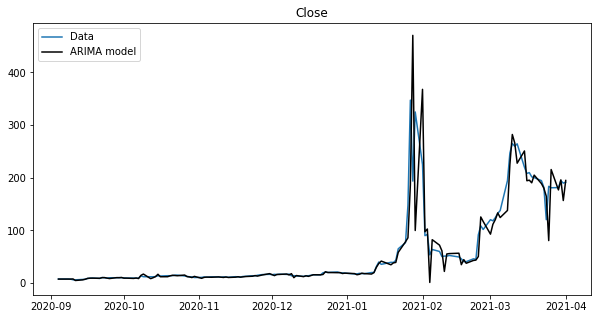

In [ ]:
model.plot_fit(figsize=(10,5))

In [ ]:
model, results = get_arimax(formula='Close~numb_pos',data=df_arimax_train) #model based on positive posts

In [ ]:
results.summary()

Normal ARIMAX(4,0,4)                                                                                      
======================================================= ==================================================
Dependent Variable: Close                               Method: MLE                                       
Start Date: 2020-09-08 00:00:00                         Log Likelihood: -656.8818                         
End Date: 2021-04-05 00:00:00                           AIC: 1335.7636                                    
Number of observations: 144                             BIC: 1368.4315                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.5525    0.2886     -1.9144  0.0556   (-1.1182 | 0.0132)       
AR(2)                                

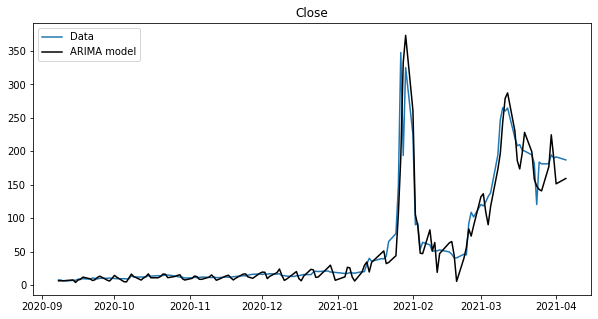

In [ ]:
model.plot_fit(figsize=(10,5))

In [ ]:
model, results = get_arimax(formula='Close~Suma',data=df_arimax_train) # model based on google trend

In [ ]:
results.summary()

Normal ARIMAX(1,0,4)                                                                                      
======================================================= ==================================================
Dependent Variable: Close                               Method: MLE                                       
Start Date: 2020-09-08 00:00:00                         Log Likelihood: -672.731                          
End Date: 2021-04-05 00:00:00                           AIC: 1361.462                                     
Number of observations: 144                             BIC: 1385.2205                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.9415     0.0563     16.7151  0.0      (0.8311 | 1.0519)        
MA(1)                                

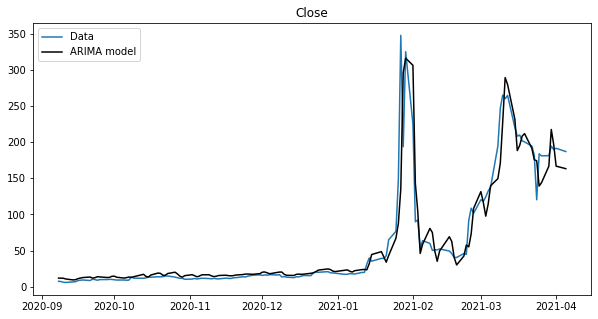

In [ ]:
model.plot_fit(figsize=(10,5))

In [ ]:
model, results = get_arimax(formula='Close~Volume+numb_pos',data=df_arimax_train) #model based on volume and positive comments

In [ ]:
results.summary()

Normal ARIMAX(3,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: Close                               Method: MLE                                       
Start Date: 2020-09-04 00:00:00                         Log Likelihood: -28833.8986                       
End Date: 2021-04-05 00:00:00                           AIC: 57685.7972                                   
Number of observations: 145                             BIC: 57712.5878                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.335      0.0095     35.1795  0.0      (0.3163 | 0.3536)        
AR(2)                                

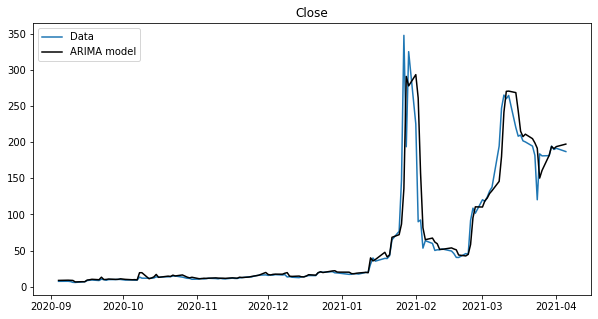

In [ ]:
model.plot_fit(figsize=(10,5))

In [ ]:
model, results = get_arimax(formula='Close~Volume+Suma',data=df_arimax_train) # model based on volume and trend

In [ ]:
results.summary()

Normal ARIMAX(1,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: Close                               Method: MLE                                       
Start Date: 2020-09-03 00:00:00                         Log Likelihood: -30310.6458                       
End Date: 2021-04-05 00:00:00                           AIC: 60635.2915                                   
Number of observations: 146                             BIC: 60656.1768                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.6199     0.004      154.4882 0.0      (0.612 | 0.6278)         
MA(1)                                

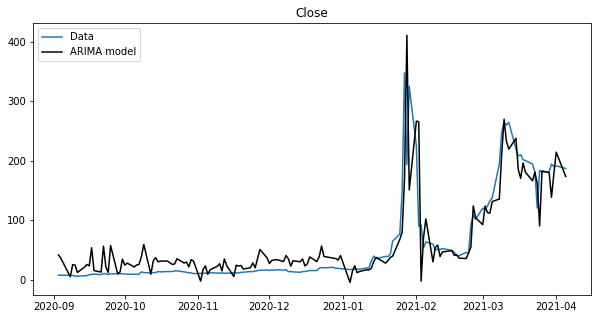

In [ ]:
model.plot_fit(figsize=(10,5))

In [ ]:
model, results = get_arimax(formula='Close~numb_pos+Suma',data=df_arimax_train) #model based on positive and trend

In [ ]:
results.summary()

Normal ARIMAX(3,0,4)                                                                                      
======================================================= ==================================================
Dependent Variable: Close                               Method: MLE                                       
Start Date: 2020-09-08 00:00:00                         Log Likelihood: -658.1198                         
End Date: 2021-04-05 00:00:00                           AIC: 1338.2397                                    
Number of observations: 144                             BIC: 1370.9076                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.2022    0.4221     -0.4791  0.6319   (-1.0295 | 0.6251)       
AR(2)                                

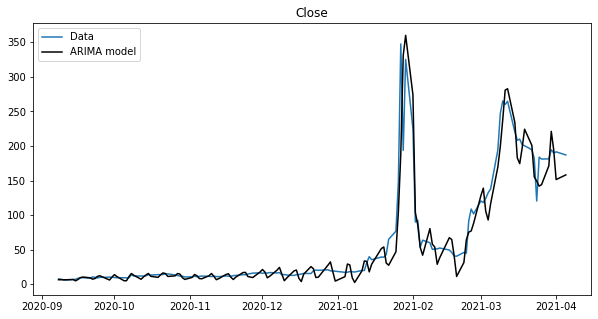

In [ ]:
model.plot_fit(figsize=(10,5))

In [ ]:
model, results = get_arimax(formula='Close~Volume+numb_pos+Suma',data=df_arimax_train) # model based on volume, positive and trend

In [ ]:
results.summary()

Normal ARIMAX(2,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: Close                               Method: MLE                                       
Start Date: 2020-09-03 00:00:00                         Log Likelihood: -29716.5521                       
End Date: 2021-04-05 00:00:00                           AIC: 59451.1042                                   
Number of observations: 146                             BIC: 59477.9566                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.4253     0.0024     176.3318 0.0      (0.4206 | 0.43)          
AR(2)                                

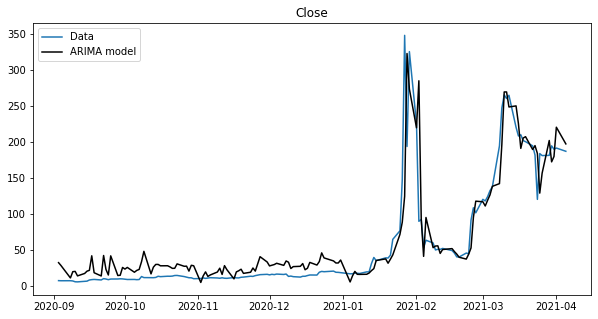

In [ ]:
model.plot_fit(figsize=(10,5))

Prediction of the best ARIMAX based on the number of positive comments
---



In [ ]:
model, results = get_arimax(formula='Close~numb_pos',data=df_arimax_train)

In [ ]:
df_arimax_test2 =df_arimax_test.copy()
df_arimax_test2['Close']=np.nan

In [ ]:
preds = model.predict(30,df_arimax_test[-30:])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_arimax_train.reset_index().Date, y=df_arimax_train.Close,name='Past Price'))
fig.add_trace(go.Scatter(x=df_arimax_test.reset_index().Date, y=df_arimax_test.Close,name='Real Price'))
fig.add_trace(go.Scatter(x=preds.reset_index().Date, y=preds.Close,name='Predictions'))
fig.show()


<h1>REINFORCEMENT LEARNING</h1>

In [ ]:
#@title Libraries

#Code from https://github.com/AI4Finance-Foundation/FinRL
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
    !pip install mysql-connector-python
import yfinance as yf
from stockstats import StockDataFrame as Sdf

import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_df = yf.download("GME", start="2020-09-01", end="2021-05-14") #łączenie danych
data_df=data_df.reset_index()
data_df.columns = ['datadate','open','high','low','close','adjcp','volume']
stock = Sdf.retype(data_df.copy())
stock['close'] = stock['adjcp']
data_df['macd'] = stock['macd']
data_clean = data_df.copy()

[*********************100%***********************]  1 of 1 completed


In [ ]:
#@title A clean raw environment
#Źródło  - https://github.com/AI4Finance-LLC/FinRL

# Zmienne
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1
TRANSACTION_FEE_PERCENT = 0.001


class SingleStockEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        self.day = day
        self.df = df
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (4,))
        self.data = self.df.loc[self.day,:]
        self.terminal = False  
        self.trades = 0
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] 
        self.reward = 0
        self.cost = 0
        
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        if self.state[index+STOCK_DIM+1] > 0:
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        available_amount = self.state[0] // self.state[index+1]
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            
            actions = actions * HMAX_NORMALIZE
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self._sell_stock(index, actions[index])

            for index in buy_index:
                self._buy_stock(index, actions[index])
            
            
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd]
                        
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd]
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [ ]:
train = data_clean[(data_clean.datadate>='2020-09-01') & (data_clean.datadate<'2021-02-10')]
train=train.reset_index(drop=True)

Model training

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=10000,tb_log_name="run_gme_ppo")

previous_total_asset:100000
end_total_asset:159668.45053783825
total_reward:59668.450537838246
total_cost:  475.0164684436848
total trades:  109
Sharpe:  1.3881570141516442
previous_total_asset:100000
end_total_asset:77677.1057802299
total_reward:-22322.894219770096
total_cost:  355.9396584316354
total trades:  100
Sharpe:  0.3669296581417877
previous_total_asset:100000
end_total_asset:128077.666052886
total_reward:28077.666052885994
total_cost:  334.8897458103394
total trades:  105
Sharpe:  1.20654480333874
previous_total_asset:100000
end_total_asset:171045.3501428838
total_reward:71045.3501428838
total_cost:  251.7856532091352
total trades:  100
Sharpe:  2.9933587724968365
previous_total_asset:100000
end_total_asset:96847.48664575811
total_reward:-3152.5133542418916
total_cost:  416.07745622937426
total trades:  99
Sharpe:  1.0963782681585326
previous_total_asset:100000
end_total_asset:276485.72771106695
total_reward:176485.72771106695
total_cost:  390.64726548376626
total trades:  1

In [ ]:
test = data_clean[(data_clean.datadate>='2021-02-11') ]
test=test.reset_index(drop=True)

Checking the model on test data

In [ ]:
model = model_ppo
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:200432.46352742065
total_reward:100432.46352742065
total_cost:  751.3459673091448
total trades:  63
Sharpe:  2.3808135676090183


In [ ]:
#@title Functions
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value
def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

In [ ]:
df_total_value=get_DRL_sharpe()
get_buy_and_hold_sharpe(test)
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

annual return:  5938.15294086583
sharpe ratio:  2.380813567609016
annual return:  187451.9246026953
sharpe ratio:  2.720622789891536


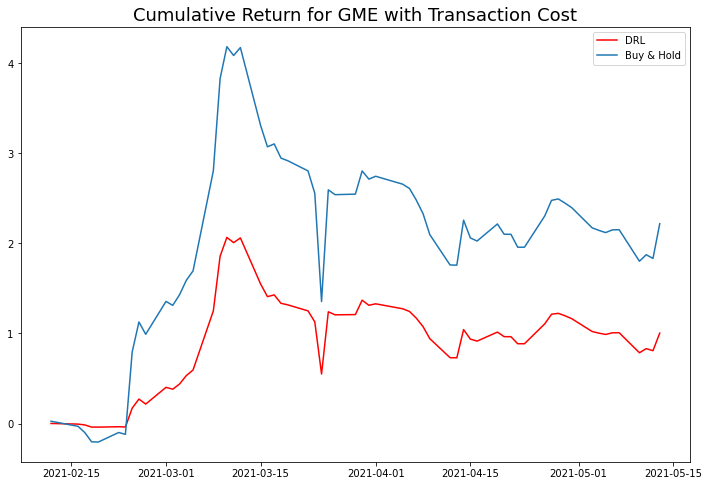

In [ ]:
%matplotlib inline #cumulative return graph 
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for GME with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)


Model dla sentymentu

In [ ]:
source = pd.read_csv('final.csv')
sent = source.filter(['Date', 'numb_pos', 'Suma' ])

In [ ]:
sent['datadate'] = sent['Date'].astype(str)
data_df['datadate'] = data_df['datadate'].astype(str)

In [ ]:
data_dff = data_df.merge(sent, on='datadate')

In [ ]:
data_dff.drop(columns=['Date', 'Suma'], inplace=True)
data_dff['datadate'] = pd.to_datetime(data_dff['datadate'], format='%Y-%m-%d')


In [ ]:
data_clean = data_dff.copy()

In [ ]:
#@title Environment with sentiment
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

TRANSACTION_FEE_PERCENT = 0.001


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        self.day = day
        self.df = df
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (5,)) #shape - ilość zmiennych(ostatnio 4, teraz 5 bo dodajemy zmienną z sentymentem)
        self.data = self.df.loc[self.day,:]
        self.terminal = False  
        self.trades = 0
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] + \
                      [self.data.numb_pos] 
        self.reward = 0
        self.cost = 0
        
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        if self.state[index+STOCK_DIM+1] > 0:
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        available_amount = self.state[0] // self.state[index+1]
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            actions = actions * HMAX_NORMALIZE
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self._sell_stock(index, actions[index])

            for index in buy_index:
                self._buy_stock(index, actions[index])
            
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd] +\
                          [self.data.numb_pos] 

            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] + \
                      [self.data.numb_pos]

        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [ ]:
train = data_clean[(data_clean.datadate>='2020-09-01') & (data_clean.datadate<'2021-02-10')]
train=train.reset_index(drop=True)

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=10000,tb_log_name="run_gme_ppo")

previous_total_asset:100000
end_total_asset:40934.6771826723
total_reward:-59065.3228173277
total_cost:  363.68615608236973
total trades:  108
Sharpe:  -0.10749896524788033
previous_total_asset:100000
end_total_asset:84881.9450482234
total_reward:-15118.054951776605
total_cost:  257.80848476669206
total trades:  109
Sharpe:  1.0273399027831394
previous_total_asset:100000
end_total_asset:177431.87767675263
total_reward:77431.87767675263
total_cost:  470.8985524681469
total trades:  98
Sharpe:  1.458526604515701
previous_total_asset:100000
end_total_asset:209103.25101516687
total_reward:109103.25101516687
total_cost:  432.85270644279484
total trades:  107
Sharpe:  1.6674817283128465
previous_total_asset:100000
end_total_asset:128802.38129263428
total_reward:28802.38129263428
total_cost:  300.21028220076073
total trades:  109
Sharpe:  1.285743010054996
previous_total_asset:100000
end_total_asset:158121.7199758416
total_reward:58121.71997584161
total_cost:  232.6266334515183
total trades: 

In [ ]:
test = data_clean[(data_clean.datadate>='2021-02-11') ]
test=test.reset_index(drop=True)

In [ ]:
model = model_ppo
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:216584.7803655036
total_reward:116584.7803655036
total_cost:  1038.0217954035945
total trades:  63
Sharpe:  3.3622863128762717


In [ ]:
df_total_value=get_DRL_sharpe()
get_buy_and_hold_sharpe(test)
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

annual return:  3511.4650189417225
sharpe ratio:  3.36228631287627
annual return:  187451.9246026953
sharpe ratio:  2.720622789891536


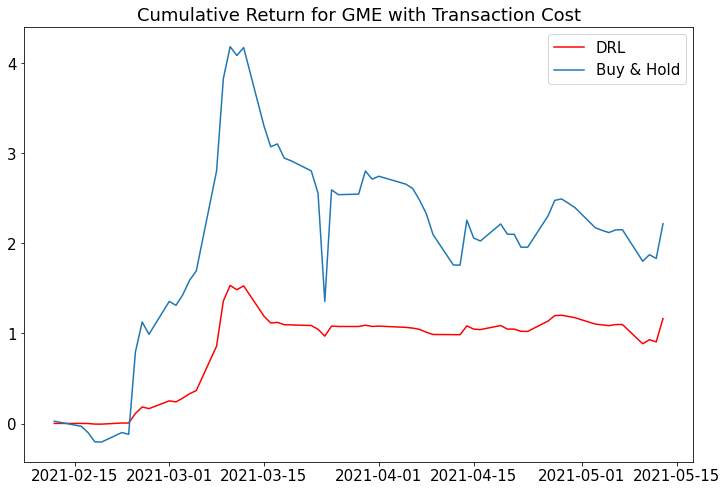

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for GME with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)


In [ ]:
data_dff = data_df.merge(sent, on='datadate')
data_dff.drop(columns=['Date', 'numb_pos'], inplace=True)
data_dff['datadate'] = pd.to_datetime(data_dff['datadate'], format='%Y-%m-%d')


In [ ]:
data_clean = data_dff.copy()

In [ ]:
#@title env with google trend
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

TRANSACTION_FEE_PERCENT = 0.001


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        self.day = day
        self.df = df
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (5,))
        self.data = self.df.loc[self.day,:]
        self.terminal = False  
        self.trades = 0
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] + \
                      [self.data.Suma]
        self.reward = 0
        self.cost = 0
        
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        if self.state[index+STOCK_DIM+1] > 0:
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        available_amount = self.state[0] // self.state[index+1]
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            actions = actions * HMAX_NORMALIZE
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self._sell_stock(index, actions[index])

            for index in buy_index:
                self._buy_stock(index, actions[index])
            
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd] +\
                          [self.data.Suma]
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] + \
                      [self.data.Suma]

        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [ ]:
train = data_clean[(data_clean.datadate>='2020-09-01') & (data_clean.datadate<'2021-02-10')]
train=train.reset_index(drop=True)

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=10000,tb_log_name="run_gme_ppo")

previous_total_asset:100000
end_total_asset:191615.3092447595
total_reward:91615.3092447595
total_cost:  349.1197001564441
total trades:  107
Sharpe:  1.9383088298893352
previous_total_asset:100000
end_total_asset:72261.90000336745
total_reward:-27738.099996632547
total_cost:  300.36246644054677
total trades:  104
Sharpe:  0.8594218819718439
previous_total_asset:100000
end_total_asset:66045.70268566703
total_reward:-33954.29731433297
total_cost:  224.6722236780552
total trades:  97
Sharpe:  -1.0100934359778826
previous_total_asset:100000
end_total_asset:62839.02956738558
total_reward:-37160.97043261442
total_cost:  321.6367254431764
total trades:  90
Sharpe:  0.4621571093226655
previous_total_asset:100000
end_total_asset:140354.1021518389
total_reward:40354.10215183889
total_cost:  406.41454674621633
total trades:  109
Sharpe:  1.1767858886082574
previous_total_asset:100000
end_total_asset:75339.30343616256
total_reward:-24660.69656383744
total_cost:  229.1225306445073
total trades:  9

In [ ]:
test = data_clean[(data_clean.datadate>='2021-02-11') ]
test=test.reset_index(drop=True)

In [ ]:
model = model_ppo
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:120020.36775160884
total_reward:20020.367751608836
total_cost:  782.9666699594978
total trades:  57
Sharpe:  1.3260890198353925


In [ ]:
df_total_value=get_DRL_sharpe()
get_buy_and_hold_sharpe(test)
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

annual return:  171.61443679273026
sharpe ratio:  1.3260890198353932
annual return:  187451.9246026953
sharpe ratio:  2.720622789891536


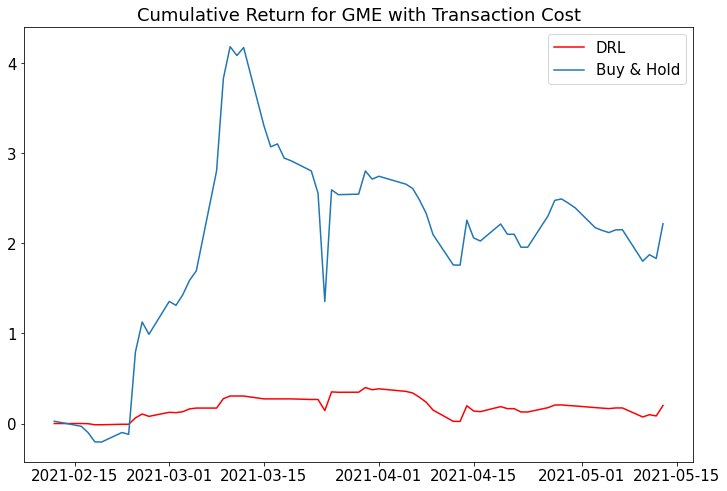

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for GME with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)


In [ ]:
data_dff = data_df.merge(sent, on='datadate')
data_dff.drop(columns=['Date'], inplace=True)
data_dff['datadate'] = pd.to_datetime(data_dff['datadate'], format='%Y-%m-%d')
data_clean = data_dff.copy()

In [ ]:
#@title Env with trend and sentiment
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

TRANSACTION_FEE_PERCENT = 0.001


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        self.day = day
        self.df = df
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (6,)) #teraz 6 zmiennych
        self.data = self.df.loc[self.day,:]
        self.terminal = False  
        self.trades = 0
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] + \
                      [self.data.Suma] + \
                      [self.data.numb_pos] #trend + sentyment
        self.reward = 0
        self.cost = 0
        
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        if self.state[index+STOCK_DIM+1] > 0:
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        available_amount = self.state[0] // self.state[index+1]
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            actions = actions * HMAX_NORMALIZE
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self._sell_stock(index, actions[index])

            for index in buy_index:
                self._buy_stock(index, actions[index])
            
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd] +\
                          [self.data.Suma] + \
                          [self.data.numb_pos] #dodanie trendu i sentymentu
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] + \
                      [self.data.Suma] + \
                      [self.data.numb_pos]


        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [ ]:
train = data_clean[(data_clean.datadate>='2020-09-01') & (data_clean.datadate<'2021-02-10')]
train=train.reset_index(drop=True)

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=10000,tb_log_name="run_gme_ppo")

previous_total_asset:100000
end_total_asset:79235.37737044305
total_reward:-20764.62262955695
total_cost:  446.62265974318376
total trades:  102
Sharpe:  0.5652279752608793
previous_total_asset:100000
end_total_asset:216810.6368710843
total_reward:116810.63687108431
total_cost:  346.4168875148569
total trades:  109
Sharpe:  1.7420086143417497
previous_total_asset:100000
end_total_asset:74240.26769515545
total_reward:-25759.732304844554
total_cost:  355.28539995558026
total trades:  106
Sharpe:  0.011873417769312071
previous_total_asset:100000
end_total_asset:252145.83578737735
total_reward:152145.83578737735
total_cost:  386.13692680852785
total trades:  101
Sharpe:  1.8325094824179675
previous_total_asset:100000
end_total_asset:90843.55028449681
total_reward:-9156.449715503186
total_cost:  256.33305939827824
total trades:  93
Sharpe:  0.26722623415338476
previous_total_asset:100000
end_total_asset:164061.83485475573
total_reward:64061.834854755725
total_cost:  204.480913919991
total t

In [ ]:
test = data_clean[(data_clean.datadate>='2021-02-11') ]
test=test.reset_index(drop=True)

In [ ]:
model = model_ppo
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:196710.31041647136
total_reward:96710.31041647136
total_cost:  853.7827026245268
total trades:  49
Sharpe:  3.7662328823000166


In [ ]:
df_total_value=get_DRL_sharpe()
get_buy_and_hold_sharpe(test)
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

annual return:  1873.3304892146364
sharpe ratio:  3.766232882300016
annual return:  187451.9246026953
sharpe ratio:  2.720622789891536


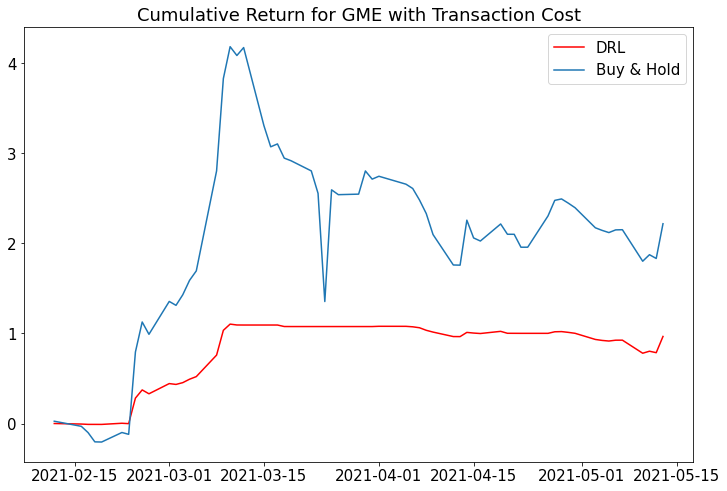

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for GME with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)


<h1>Sentiment is the best way to improve predictions and Reinforcement Learning model to trading money in the stock market. Volume is underperforming.</h1>